In [14]:
!pip install numba
import random
import glob
import os
import sys
import calendar
import pickle
from pathlib import Path
from datetime import datetime, timedelta
from typing import List, Optional, Callable, Dict, Union, Tuple
from collections import defaultdict
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint, adfuller
from joblib import Parallel, delayed
from concurrent.futures import ThreadPoolExecutor, as_completed
from IPython.core.debugger import set_trace
from itertools import chain, combinations, islice
from statsmodels.regression.linear_model import OLS
from statsmodels.tools import add_constant
from numba import njit
import json
# This code was developed with the assistance of multiple AI agents (e.g., Perplexity, August 2025).



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sys

In [3]:
%pwd

'C:\\Users\\mangl\\Desktop\\capstone\\pair_selection'

In [4]:
BASE_DIR = "../downloaded_files"
RUN_DATE = "2021-04-01"
LOOKBACK = 60
MIN_MEAN_REVERSION = 0.04

In [5]:

class StockDataLoader:
    def __init__(
        self,
        tickers: List[str],
        start: Union[str, datetime],
        end: Union[str, datetime],
        agg_func: Optional[Union[str, Callable]] = None,
        resample_freq: Optional[str] = None,
        select_columns: Optional[List[str]] = None,
        impute: bool = True,
        base_dir: Optional[Union[str, Path]] = "../downloaded_files",
    ):
        # Make attributes private
        self._start = self._parse_datetime(start)
        self._end = self._parse_datetime(end)
        self._base_dir = Path(base_dir)
        
        self._tickers = tickers or self._find_available_tickers()
        
        self._agg_func = agg_func
        self._resample_freq = resample_freq
        self._select_columns = select_columns  
        self._impute = impute

        # Cache for storing loaded data
        self._data_cache: Dict[str, pl.DataFrame] = {}

        # Column mapping for renaming
        self._rev_cols_map = {
            "open_interest": "<o/i> ",
            "date": "<date>",
            "time": "<time>",
            "open": "<open>",
            "high": "<high>",
            "low": "<low>",
            "close": "<close>",
            "volume": "<volume>",
        }
        self._cols_map = {
            "<o/i> ": "open_interest",
            "<date>": "date",
            "<time>": "time",
            "<open>": "open",
            "<high>": "high",
            "<low>": "low",
            "<close>": "close",
            "<volume>": "volume"
        }
        self._new_columns, self._columns = zip(*self._rev_cols_map.items())
        if self._select_columns:
            self._new_columns = self._select_columns + ["date", "time"]
            self._columns = [self._rev_cols_map[c] for c in self._new_columns]

        self._schema = {
             "date": pl.String,
            "time":pl.String,
            "datetime": pl.Datetime("us"),
            "open_price": pl.Float64,
            "high_price": pl.Float64,
            "low_price": pl.Float64,
            "close_price": pl.Float64,
            "volume": pl.Float64,
            "open_interest": pl.Float64,
        }
    def _find_available_tickers(self) -> List[str]:
        """Find all tickers present across all months by set intersection."""
        months = self._generate_monthly_files()
        all_month_tickers = []

        for month in months:
            folder = self._get_month_dir(month)
            if not folder.exists():
                continue

            tickers_in_month = {
                f.stem for f in folder.glob("*.csv") if f.is_file()
            }
            if tickers_in_month:
                all_month_tickers.append(tickers_in_month)

        # If no CSVs found at all
        if not all_month_tickers:
            raise FileNotFoundError(
                f"No CSV files found in any month between {self._start} and {self._end}"
            )

        # Take intersection to get tickers present in *all* months
        common_tickers = set.intersection(*all_month_tickers)
        if not common_tickers:
            raise ValueError(
                "No common tickers found across all months in the given date range."
            )

        return sorted(common_tickers)
    def _parse_datetime(self, dt):
        """Ensure datetime parsing."""
        if isinstance(dt, datetime):
            return dt
        return datetime.strptime(dt, "%Y-%m-%d %H:%M:%S")

    def _generate_monthly_files(self):
        """Generate list of months between start and end."""
        start_month = self._start.replace(day=1)
        end_month = self._end.replace(day=1)

        months = []
        while start_month <= end_month:
            months.append(start_month.strftime("%Y-%m"))  # e.g. "2025-01"
            start_month += timedelta(days=32)
            start_month = start_month.replace(day=1)
        return months

    def _get_month_dir(self, month: str) -> Path:
        """
        Construct the directory path dynamically based on new structure:
        ../downloaded_files/{year}/Cash Data {month_name} {year}
        """
        
        year, month_num = month.split("-")
        month_name = calendar.month_name[int(month_num)]
        
        return self._base_dir / year / f"Cash Data {month_name} {year}"

    def _empty_df(self) -> pl.DataFrame:
        """Return an empty DataFrame with correct schema."""
        return pl.DataFrame(schema=self._schema)
        
    def _load_single_file(self, ticker: str, month: str) -> pl.DataFrame:
        """Load and preprocess a single month's CSV for one ticker."""
        folder = self._get_month_dir(month)
        file_path = folder / f"{ticker}.csv"
    
        # If file doesn't exist → return empty DataFrame with correct schema
        if not file_path.exists():
            return self._empty_df()
    
        # Read CSV with only required columns and rename them
        df = pl.read_csv(file_path, columns=self._columns)
        df = df.rename({i: self._cols_map[i] for i in df.columns})
    
        # Combine date & time into datetime column, sort, and drop originals
        df = df.with_columns(
            pl.concat_str([df["date"], df["time"]], separator=" ")
            .str.strptime(pl.Datetime, format="%m/%d/%Y %H:%M:%S")
            .alias("datetime")
        ).drop(["date", "time"]).sort("datetime")
    
        df = df.set_sorted("datetime")
        return df
    
    def _merge_monthly_data(self, ticker: str) -> pl.DataFrame:
        """Read multiple monthly files, combine them, handle imputation, and resampling."""
        months = self._generate_monthly_files()
        dfs = [self._load_single_file(ticker, month) for month in months]
        dfs = [d for d in dfs if not d.is_empty()]
    
        if not dfs:
            return self._empty_df()
    
        # 1) Concatenate all months
        df = pl.concat(dfs, how="vertical")
    
        # 2) Sort by datetime
        df = df.sort("datetime")
    
        # 3) Drop duplicates
        df = df.unique(subset=["datetime"], keep="last", maintain_order=True)
    
        # 4) Trim to requested global range BEFORE imputation
        df = df.filter((pl.col("datetime") >= self._start) & (pl.col("datetime") <= self._end))
    
        # 5) Global imputation: forward fill + backward fill
        if self._impute:
            time_range = pl.DataFrame({
                "datetime": pl.datetime_range(
                    start=self._start,
                    end=self._end,
                    interval="1m",
                    eager=True
                )
            })
            df = time_range.join(df, on="datetime", how="left")
            df = df.fill_null(strategy="forward").fill_null(strategy="backward")
    
        # 6) Resample if needed
        if not df.is_empty() and self._resample_freq:
            func = self._agg_func or "mean"
            df = df.group_by_dynamic(
                time_column="datetime",
                every=self._resample_freq,
                closed="left"
            ).agg({col: func for col in df.columns if col != "datetime"})
            df = df.sort("datetime")
    
        # 7) Keep only selected columns
        keep_cols = ["datetime"] + [col for col in self._new_columns if col in df.columns]
        return df.select(keep_cols)

    def get_data_for_tickers(self, tickers: Optional[List[str]] = None) -> Dict[str, pl.DataFrame]:
        """
        Public method: Returns processed data for one or more tickers.
        Uses cache when available.
        Fully parallelized using joblib with all available CPU cores.
        """
        if not tickers:
            tickers = self._tickers
        else:
            tickers = [t for t in tickers if t in self._tickers]

        if not tickers:
            raise ValueError("No valid tickers provided or found.")

        # Use all available cores
        n_jobs = os.cpu_count() or 1

        # Run in parallel for all tickers
        results_list = Parallel(n_jobs=n_jobs, backend="loky")(
            delayed(self._load_or_get_from_cache)(ticker) for ticker in tickers
        )

        # Combine ticker names with their data
        return dict(zip(tickers, results_list))

    def _load_or_get_from_cache(self, ticker: str) -> pl.DataFrame:
        """Helper to either fetch from cache or load fresh."""
        if ticker not in self._data_cache:
            self._data_cache[ticker] = self._merge_monthly_data(ticker)
        return self._data_cache[ticker]

In [6]:
# loader = StockDataLoader(
#     tickers=[],
#     start="2021-12-02 09:15:00",
#     end="2022-03-02 15:30:00",
#     # resample_freq="5m",
#     select_columns=["volume"],
#     base_dir="../downloaded_files",
#     impute = True
# )
# data_dict = loader.get_data_for_tickers();


In [7]:
 
class LiquidityPredictor:
    def __init__(
        self,
        base_dir: str,
        run_date: str,
        lookback: int,
        trading_start: str = "09:15:00",
        trading_end: str = "15:30:00",
        time_interval_minutes: int = 60,
        tickers: Optional[List[str]] = None
    ):
        self.base_dir = base_dir
        
        # Convert run_date to datetime
        self.run_date = datetime.strptime(run_date, "%Y-%m-%d")
        
        # Set start and end dates implicitly
        self.end_day = self.run_date
        self.start_day = self.run_date - timedelta(days=lookback)
        
        # Market timings
        self.start_time = datetime.strptime(trading_start, "%H:%M:%S").time()
        self.end_time = datetime.strptime(trading_end, "%H:%M:%S").time()
        self.time_interval = timedelta(minutes=time_interval_minutes)
        
        # Stock tickers (optional)
        self.tickers = tickers
        
        # Logging for debugging
        self._log_initial_config()

    def _log_initial_config(self):
        print(f"Base directory: {self.base_dir}")
        print(f"Run Date: {self.run_date.date()}")
        print(f"Start Day: {self.start_day.date()}")
        print(f"End Day: {self.end_day.date()}")
        print(f"Trading Window: {self.start_time} → {self.end_time}")
        print(f"Tickers: {self.tickers if self.tickers else 'Using default universe'}")

        
    def filter_basic(self, volume_threshold: int = 1000) -> List[str]:
        """
        Basic filtering by average volume.
        Returns tickers passing the volume threshold.
        """
        loader = StockDataLoader(
            tickers=self.tickers,
            start=f"{self.start_day.strftime('%Y-%m-%d')} {self.start_time}",
            end=f"{self.end_day.strftime('%Y-%m-%d')} {self.end_time}",
            select_columns=["volume"],
            base_dir=self.base_dir
        )
        data_dict = loader.get_data_for_tickers()
        filtered = []

        for ticker, df in data_dict.items():
            if not df.is_empty() and df["volume"].mean() >= volume_threshold:
                filtered.append(ticker)

        return filtered

    def filter_advanced(
        self,
        tickers: List[str],
        custom_weights: Optional[Dict[str, float]] = None,
        min_score: float = 30.0
    ) -> List[str]:
        """
        Advanced filtering: compute metrics, weighted score, and return ranked tickers.
        Returns list of tickers sorted by liquidity (highest first).
        """
        if custom_weights is None:
            custom_weights = {
                "average_volume": 0.4,
                "trading_frequency": 0.3,
                "amihud_liquidity": 0.2,
                "volume_consistency": 0.1
            }

        loader = StockDataLoader(
            tickers=tickers,
            start=f"{self.start_day.strftime('%Y-%m-%d')} {self.start_time}",
            end=f"{self.end_day.strftime('%Y-%m-%d')} {self.end_time}",
            select_columns=["volume", "close", "open"],
            base_dir=self.base_dir
        )
        data_dict = loader.get_data_for_tickers()

        scores = []
        for ticker, df in data_dict.items():
            score = self._compute_weighted_score(df, custom_weights)
            if score is not None and score >= min_score:
                scores.append((ticker, score))

        # Sort by descending score
        scores.sort(key=lambda x: x[1], reverse=True)
        return [t[0] for t in scores]

    def _compute_weighted_score(self, df: pl.DataFrame, weights: Dict[str, float]) -> Optional[float]:
 
        avg_volume = self._compute_average_volume_score(df)
        trading_freq = self._compute_trading_frequency_score(df)
        amihud = self._compute_amihud_liquidity_score(df)
        volume_consistency = self._compute_volume_consistency_score(df)
     
        return (
            avg_volume * weights["average_volume"] +
            trading_freq * weights["trading_frequency"] +
            amihud * weights["amihud_liquidity"] +
            volume_consistency * weights["volume_consistency"]
        )

    def _compute_average_volume_score(self, df: pl.DataFrame) -> float:
        """Log-normalized average volume (0-100)."""
        mean = df["volume"].mean()
        return min(100, max(0, (np.log10(mean) - 2) / 5 * 100))
    
    def _compute_trading_frequency_score(self, df: pl.DataFrame) -> float:
        """Percentage of periods with volume > 0."""
        total = df.height
        active = df.filter(pl.col("volume") > 0).height
        return active / total * 100
        
    def _compute_amihud_liquidity_score(self, df: pl.DataFrame) -> float:
        """
        Computes the Amihud Illiquidity Score.
        Lower score = more liquid, higher = less liquid.
        Formula: ILLIQ = (1/D) * Σ(|R| / VOL)
        """
        df = df.with_columns((pl.col("close").pct_change().abs()).alias("return"))    
        df = df.filter(pl.col("volume") > 0)
    
        df = df.with_columns((pl.col("return") / pl.col("volume")).alias("amihud"))
        illiq = df["amihud"].mean()
        return illiq

    def _compute_volume_consistency_score(self, df: pl.DataFrame) -> float:
        """Score based on volume coefficient of variation (CV)."""
        mean = df["volume"].mean()
        std = df["volume"].std()
        cv = std / mean
        return 100 - cv * 30 if cv <= 1 else 70 * np.exp(-(cv - 1) * 0.5)


In [8]:
predictor = LiquidityPredictor(
    base_dir=BASE_DIR,
    lookback=LOOKBACK,
    run_date=RUN_DATE,
    tickers  = []
)
# Basic filter: only tickers with avg volume >= 1000
basic_tickers = predictor.filter_basic(volume_threshold=1000)
print("Tickers passing basic volume filter:", basic_tickers)


Base directory: ../downloaded_files
Run Date: 2021-04-01
Start Day: 2021-01-31
End Day: 2021-04-01
Trading Window: 09:15:00 → 15:30:00
Tickers: Using default universe
Tickers passing basic volume filter: ['3IINFOTECH', 'A2ZINFRA', 'ABCAPITAL', 'ABFRL', 'ACE', 'ADANIENT', 'ADANIGREEN', 'ADANIPORTS', 'ADANIPOWER', 'ADANITRANS', 'AGROPHOS', 'AIRAN', 'AKSHOPTFBR', 'ALCHEM', 'ALEMBICLTD', 'ALOKINDS', 'ALPSINDUS', 'AMBUJACEM', 'ANANTRAJ', 'ANDHRACEMT', 'ANKITMETAL', 'ANSALAPI', 'APOLLOHOSP', 'APOLLOTYRE', 'ARCHIES', 'ARVIND', 'ASHIMASYN', 'ASHOKA', 'ASHOKLEY', 'ASIANPAINT', 'ATGL', 'AUBANK', 'AUROPHARMA', 'AVTNPL', 'AXISBANK', 'BAGFILMS', 'BAJAJCON', 'BAJAJHIND', 'BAJFINANCE', 'BALLARPUR', 'BALMLAWRIE', 'BALRAMCHIN', 'BANDHANBNK', 'BANKBARODA', 'BANKBEES', 'BANKINDIA', 'BCG', 'BCP', 'BEL', 'BEPL', 'BHANDARI', 'BHARATFORG', 'BHARTIARTL', 'BHEL', 'BILENERGY', 'BIOCON', 'BKMINDST', 'BLKASHYAP', 'BLUECHIP', 'BODALCHEM', 'BOMDYEING', 'BPCL', 'BRFL', 'BURGERKING', 'BURNPUR', 'BYKE', 'CADILAHC', 'C

In [9]:
# Advanced filter: rank tickers by liquidity
liquid_tickers = predictor.filter_advanced(
    tickers=basic_tickers,
    custom_weights={
        "average_volume": 0.4,
        "trading_frequency": 0.3,
        "amihud_liquidity": 0.2,
        "volume_consistency": 0.1
    },
    min_score=30.0  # minimum liquidity score to include
)

print("Ranked liquid tickers:", liquid_tickers)


Ranked liquid tickers: ['IDEA', 'YESBANK', 'PNB', 'GTLINFRA', 'SAIL', 'TATAMOTORS', 'BHEL', 'SANWARIA', 'IDFCFIRSTB', 'BANKBARODA', 'BALLARPUR', 'KSERASERA', 'TATAPOWER', 'SBIN', 'ITC', 'IRFC', 'IOC', 'IDBI', 'ICICIBANK', 'SUZLON', 'NATIONALUM', 'MERCATOR', 'SOUTHBANK', 'JUMPNET', 'TTML', 'JPPOWER', 'ONGC', 'CANBK', 'ASHOKLEY', 'SITINET', 'NTPC', 'STAMPEDE', 'FEDERALBNK', 'GVKPIL', 'RPOWER', 'GAIL', 'IBULHSGFIN', 'GAYAHWS', 'UCOBANK', 'VEDL', 'TATASTEEL', 'CENTRALBK', 'GAMMNINFRA', 'TRIDENT', 'SUNDARAM', 'FCSSOFT', 'AXISBANK', 'NBCC', 'DLF', 'RCOM', 'VAKRANGEE', 'RBLBANK', 'GMRINFRA', 'L&TFH', 'VIKASMCORP', 'HINDALCO', 'UNIONBANK', 'HFCL', 'COALINDIA', 'SUBEXLTD', 'EASTSILK', 'HDFCBANK', 'BEL', 'ZEEL', 'KGL', 'LSIL', 'MOTHERSUMI', 'RELIANCE', 'IBREALEST', 'NMDC', 'ADANIPOWER', 'CASTEXTECH', 'SPCENET', 'BHARTIARTL', 'RVNL', 'TV18BRDCST', 'IDFC', 'SMPL', 'ADANIPORTS', 'UJAAS', 'GENUSPAPER', 'RTNPOWER', 'WIPRO', 'INDUSINDBK', 'IOB', '3IINFOTECH', 'A2ZINFRA', 'SUNPHARMA', 'ZICOM', 'JINDALS

In [10]:

class PairTradingAnalyzer:
    def __init__(
        self,
        base_dir: str,
        run_date: str,
        lookback: int,
        trading_start: str = "09:15:00",
        trading_end: str = "15:30:00",
        time_interval_minutes: int = 60,
        tickers: Optional[List[str]] = None,
        min_mean_reversion: float = 0.5  # <-- add as class attribute
    ):
        self.base_dir = base_dir
        self.run_date = datetime.strptime(run_date, "%Y-%m-%d")
        self.end_day = self.run_date
        self.start_day = self.run_date - timedelta(days=lookback)
        self.start_time = datetime.strptime(trading_start, "%H:%M:%S").time()
        self.end_time = datetime.strptime(trading_end, "%H:%M:%S").time()
        self.time_interval = timedelta(minutes=time_interval_minutes)
        self.tickers = tickers
        self.min_mean_reversion = min_mean_reversion  # store it here
        self._log_initial_config()


    def _log_initial_config(self):
        print("=" * 50)
        print("        PAIR TRADING ANALYZER CONFIGURATION")
        print("=" * 50)
        print(f"Base Directory     : {self.base_dir}")
        print(f"Run Date           : {self.run_date.date()}")
        print(f"Start Day          : {self.start_day.date()}")
        print(f"End Day            : {self.end_day.date()}")
        print(f"Trading Window     : {self.start_time} → {self.end_time}")
        print(f"Interval           : {self.time_interval}")
        print(f"Tickers            : {self.tickers if self.tickers else 'Using default universe'}")
        print("=" * 50)
                
    def filter_basic(self, volatility_threshold: float = 0.005) -> List[str]:
        """Return tickers with sufficient price movement."""
        loader = StockDataLoader(
            tickers=self.tickers,
            start=f"{self.start_day.strftime('%Y-%m-%d')} {self.start_time}",
            end=f"{self.end_day.strftime('%Y-%m-%d')} {self.end_time}",
            select_columns=["close"],
            base_dir=self.base_dir
        )
        data_dict = loader.get_data_for_tickers()
        self.data_dict = data_dict  # cache data to avoid reloading
        filtered = []

        for ticker, df in data_dict.items():
            returns = df["close"].pct_change().abs()
            avg_volatility = returns.mean()
            if avg_volatility >= volatility_threshold:
                filtered.append(ticker)
        self.filtered_tickers = filtered
        print(filtered)
        return filtered

    def compute_features(self) -> Dict[str, np.ndarray]:
        """Compute features for clustering."""
        features = {}
        for ticker in self.filtered_tickers:
            df = self.data_dict[ticker]
            prices = df["close"].to_numpy()
            returns = np.diff(prices) / prices[:-1]

            # Feature vector: mean-reversion, volatility, autocorrelation
            rolling_mean = np.convolve(prices, np.ones(5)/5, mode='valid')
            deviations = prices[4:] - rolling_mean
            mean_rev_score = np.mean(np.abs(deviations))
            vol_score = np.mean(np.abs(returns))
            autocorr_score = np.corrcoef(returns[:-1], returns[1:])[0, 1]

            features[ticker] = np.array([mean_rev_score, vol_score, autocorr_score])
        self.features = features
        return features

    def cluster_stocks(self, n_clusters: int = 5) -> Dict[int, List[str]]:
        """Cluster stocks based on feature vectors."""
        tickers = list(self.features.keys())
        X = np.array(list(self.features.values()))
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        clusters = {i: [] for i in range(n_clusters)}
        for ticker, label in zip(tickers, labels):
            clusters[label].append(ticker)
        self.clusters = clusters
        return clusters
        
    def _check_pair(self, t1: str, t2: str) -> Optional[List[str]]:
        prices1 = self.data_dict[t1]["close"].to_numpy()
        prices2 = self.data_dict[t2]["close"].to_numpy()
    
        # Beta hedge ratio
        X = add_constant(prices2)
        model = OLS(prices1, X).fit()
        beta = model.params[1]
    
        # Spread
        spread = prices1 - beta * prices2
    
        # Cointegration test
        score, pvalue, _ = coint(prices1, prices2)
        if pvalue >= 0.05:
            return None
    
        # Stationarity test
        adf_result = adfuller(spread)
        if adf_result[1] >= 0.05:
            return None
    
        # Minimum mean-reversion filter
        mean_rev_score = np.mean(np.abs(spread - np.mean(spread)))
        if mean_rev_score < self.min_mean_reversion:
            return None
    
        return  {
            "tickers": [t1, t2],
            "beta": float(beta),
            "mean_reversion_score": float(mean_rev_score)
        }
    
    def find_pairs_in_cluster(self, cluster_tickers: List[str], n_jobs: int = -1) -> List[List[str]]:
        """Generate pairs of tickers that are cointegrated and stationary in parallel."""
        
        # Generate all unique ticker pairs
        ticker_pairs = list(combinations(cluster_tickers, 2))
        print("Cluster:: ", len(ticker_pairs), cluster_tickers)
    
        # Use joblib to parallelize the _check_pair function
        results = Parallel(n_jobs=n_jobs)(
            delayed(self._check_pair)(t1, t2) for t1, t2 in ticker_pairs
        )
    
        # Filter out None results
        pairs = [res for res in results if res is not None]
        
        print(pairs)
        print("=="*50)
        return pairs
        
        
    def analyze(self, volatility_threshold: float = 0.001, n_clusters: int = 5) -> Dict[str, Dict]:
        """Full pipeline: filter, compute features, cluster, find pairs."""
        self.filter_basic(volatility_threshold)
        self.compute_features()
        self.cluster_stocks(n_clusters=n_clusters)
        
        # clusters = random.sample(self.clusters, 10)

        output = {}
        for cluster_id, tickers in self.clusters.items():
            
            pairs = self.find_pairs_in_cluster(tickers, n_jobs=1)  # sequential
            output[f"cluster_{cluster_id}"] = {"tickers": tickers, "pairs": pairs}
    
        return output
    


In [11]:
analyzer = PairTradingAnalyzer(
    base_dir=BASE_DIR,
    run_date=RUN_DATE,
    lookback=LOOKBACK,
    tickers = liquid_tickers,
    min_mean_reversion = MIN_MEAN_REVERSION
)


result = analyzer.analyze(volatility_threshold=0.001, n_clusters=5)

for cluster_name, cluster_info in result.items():
    print(f"{cluster_name}:")
    print("Tickers:", cluster_info["tickers"])
    print("Pairs:", cluster_info["pairs"])
    print("-" * 40)
    

        PAIR TRADING ANALYZER CONFIGURATION
Base Directory     : ../downloaded_files
Run Date           : 2021-04-01
Start Day          : 2021-01-31
End Day            : 2021-04-01
Trading Window     : 09:15:00 → 15:30:00
Interval           : 1:00:00
Tickers            : ['IDEA', 'YESBANK', 'PNB', 'GTLINFRA', 'SAIL', 'TATAMOTORS', 'BHEL', 'SANWARIA', 'IDFCFIRSTB', 'BANKBARODA', 'BALLARPUR', 'KSERASERA', 'TATAPOWER', 'SBIN', 'ITC', 'IRFC', 'IOC', 'IDBI', 'ICICIBANK', 'SUZLON', 'NATIONALUM', 'MERCATOR', 'SOUTHBANK', 'JUMPNET', 'TTML', 'JPPOWER', 'ONGC', 'CANBK', 'ASHOKLEY', 'SITINET', 'NTPC', 'STAMPEDE', 'FEDERALBNK', 'GVKPIL', 'RPOWER', 'GAIL', 'IBULHSGFIN', 'GAYAHWS', 'UCOBANK', 'VEDL', 'TATASTEEL', 'CENTRALBK', 'GAMMNINFRA', 'TRIDENT', 'SUNDARAM', 'FCSSOFT', 'AXISBANK', 'NBCC', 'DLF', 'RCOM', 'VAKRANGEE', 'RBLBANK', 'GMRINFRA', 'L&TFH', 'VIKASMCORP', 'HINDALCO', 'UNIONBANK', 'HFCL', 'COALINDIA', 'SUBEXLTD', 'EASTSILK', 'HDFCBANK', 'BEL', 'ZEEL', 'KGL', 'LSIL', 'MOTHERSUMI', 'RELIANCE'

In [12]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"pair_trading_result_{timestamp}.json"

with open(filename, "w") as f:
    json.dump(result, f, indent=4)

print(f"Saved result to {filename}")

Saved result to pair_trading_result_20250825_104411.json


Mean trading volume for all the stocks for the month

Loading pair_trading_result_20250825_104411.json


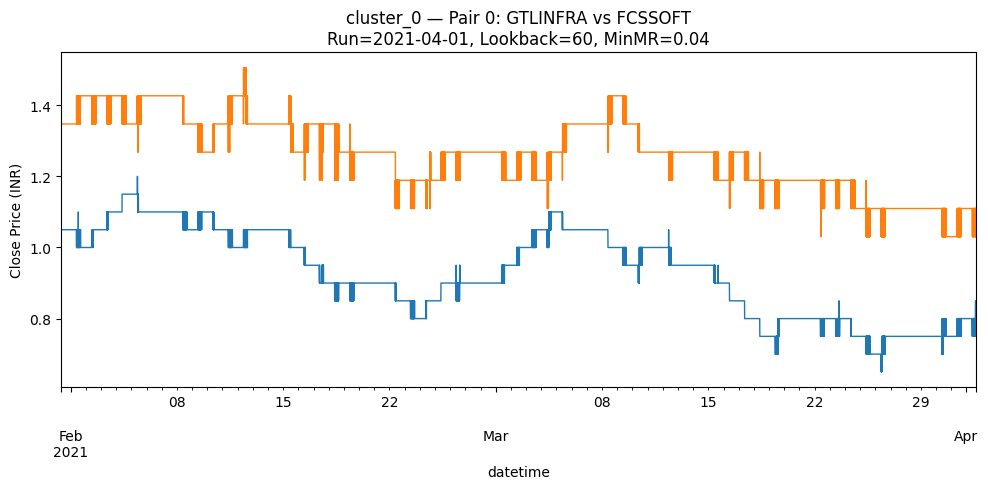

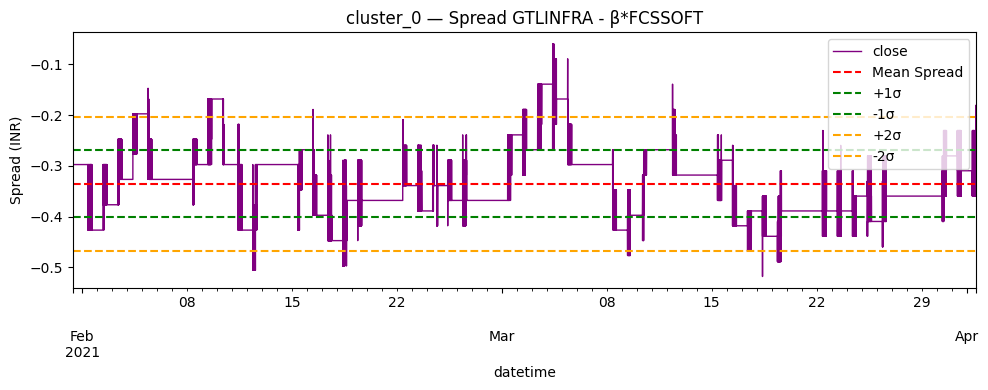

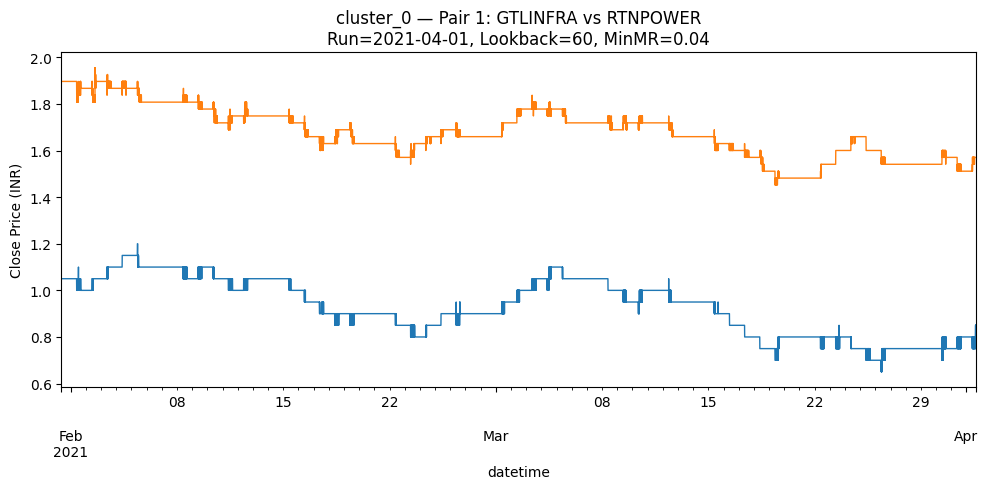

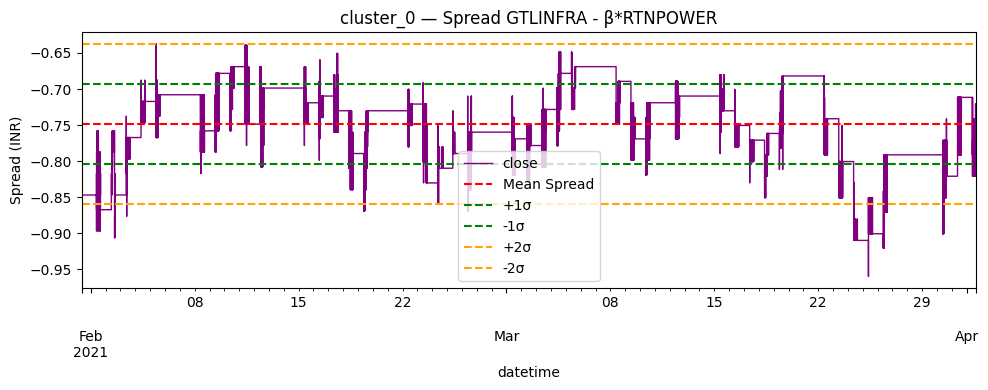

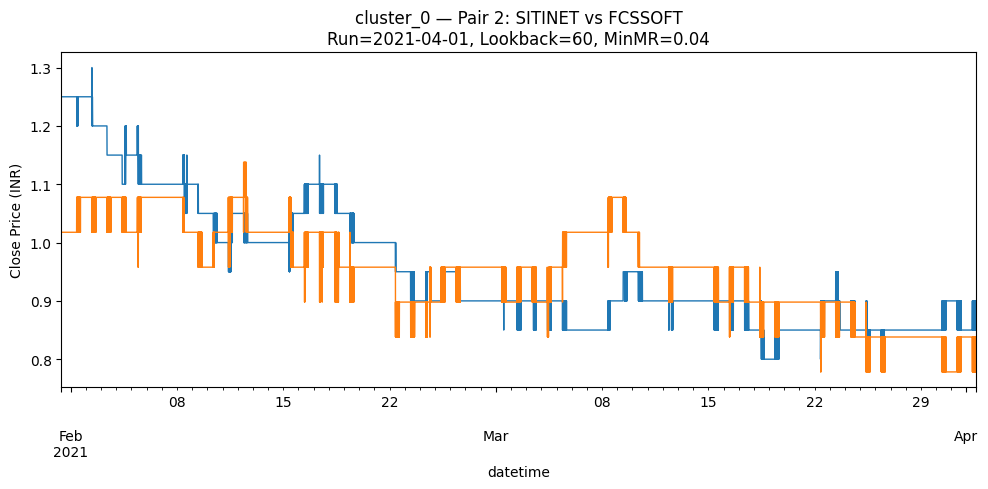

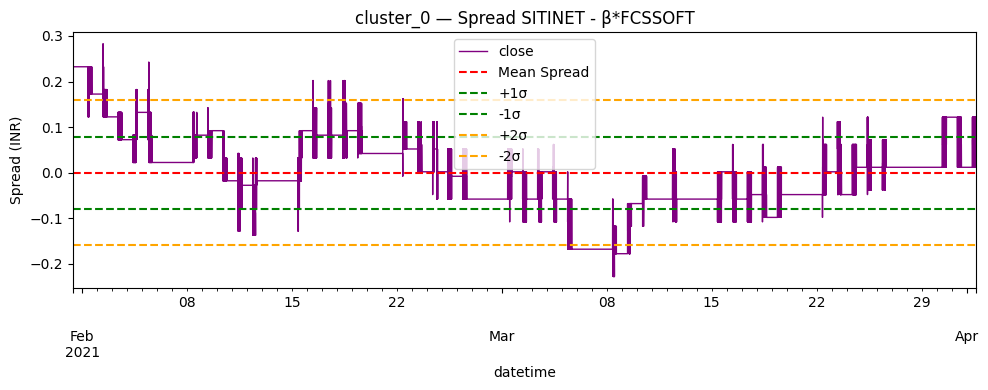

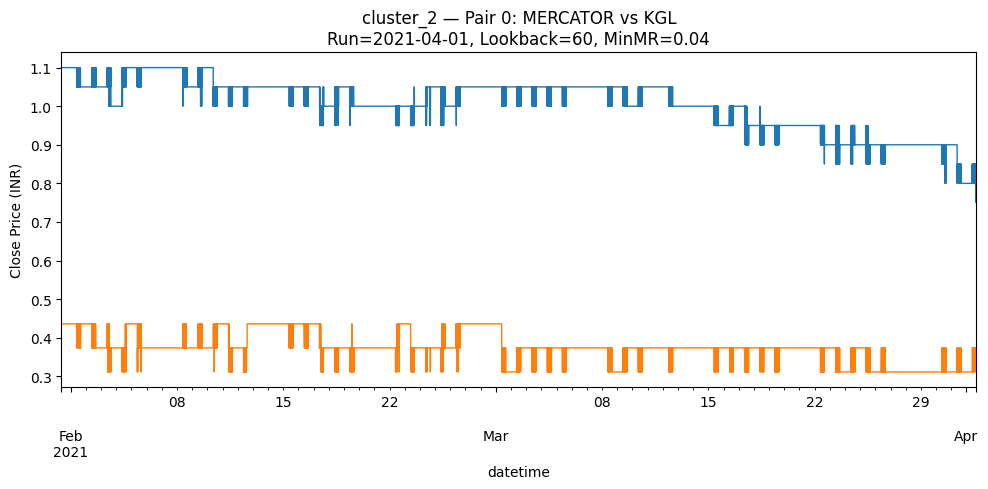

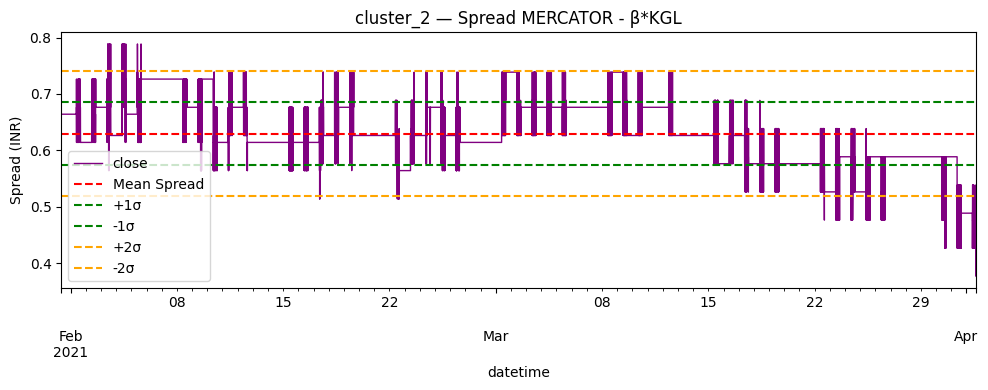

In [16]:
end_dt = datetime.strptime(RUN_DATE, "%Y-%m-%d")
start_dt = end_dt - timedelta(days=LOOKBACK)
start_str = start_dt.strftime("%Y-%m-%d 09:15:00")
end_str   = end_dt.strftime("%Y-%m-%d 15:30:00")

files = glob.glob("pair_trading_result_*.json")
latest_file = max(files, key=os.path.getmtime)
print(f"Loading {latest_file}")
with open(latest_file, "r") as f:
    result = json.load(f)


def plot_pairs_in_cluster(cluster_name, cluster_data, start, end, base_dir=BASE_DIR):
    """Plot all pairs inside a given cluster dict (closes + spread)."""
    pairs = cluster_data.get("pairs", [])
    
    for i, pair_info in enumerate(pairs):
        if isinstance(pair_info, dict):
            tickers = pair_info["tickers"]
            beta = pair_info.get("beta", 1.0)
        else:
            tickers = pair_info
            beta = 1.0

        loader = StockDataLoader(
            tickers=tickers,
            start=start,
            end=end,
            select_columns=["close"],
            base_dir=base_dir,
            impute=True
        )
        data_dict = loader.get_data_for_tickers()

        dfs = {}
        for t, pl_df in data_dict.items():
            pd_df = pl_df.to_pandas()
            pd_df = pd_df.set_index("datetime")
            dfs[t] = pd_df["close"]


        t1, t2 = tickers
        s1 = dfs[t1]
        s2 = dfs[t2]
        spread = s1 - beta * s2

        # --- Plot closes ---
        plt.figure(figsize=(10,5))
        s1.rename(t1).plot(linewidth=1)
        (beta*s2).rename(f"{t2} * β({beta:.2f})").plot(linewidth=1)
        plt.title(
            f"{cluster_name} — Pair {i}: {t1} vs {t2}\n"
            f"Run={RUN_DATE}, Lookback={LOOKBACK}, MinMR={MIN_MEAN_REVERSION}"
        )
        plt.ylabel("Close Price (INR)")
        plt.tight_layout()
        plt.show()

        # --- Plot spread with mean & std bands ---
        plt.figure(figsize=(10,4))
        spread.plot(linewidth=1, color="purple")
        mean, std = spread.mean(), spread.std()
        plt.axhline(mean, color="red", linestyle="--", label="Mean Spread")
        plt.axhline(mean+std, color="green", linestyle="--", label="+1σ")
        plt.axhline(mean-std, color="green", linestyle="--", label="-1σ")
        plt.axhline(mean+2*std, color="orange", linestyle="--", label="+2σ")
        plt.axhline(mean-2*std, color="orange", linestyle="--", label="-2σ")
        plt.title(f"{cluster_name} — Spread {t1} - β*{t2}")
        plt.ylabel("Spread (INR)")
        plt.legend()
        plt.tight_layout()
        plt.show()


# --- driver ---
for cluster_name, cluster_data in result.items():
    plot_pairs_in_cluster(
        cluster_name,
        cluster_data,
        start=start_str,
        end=end_str,
        base_dir=BASE_DIR
    )